In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
# 
dst = xr.open_dataset("population_dataset_time.nc")

N = len(dst.kappa)
NT = len(dst.t)
print(N)

# import cmocean as cmo

15


In [2]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharey=True, sharex=True)
# axs = axs.flatten()
# NT = len(dst.t.values)
# ik = 14 #14
# ir = N-1
# depths = [0, 5, 10, 14]
# for j in range(0,4):
#     ratio = dst.ratio.values[ir]
#     depth = dst.depth.values[depths[j]]
#     plt.suptitle("$H_1$/H = %2.1f" % (ratio))
#     axs[j].set_title("Depth = %2.2f m" % (depth))

#     for i in range(0,N): 
#         # depth = dst.depth.values[i]
#         kappa = dst.kappa.values[i]
#         diff_d = dst.d1.values[:, depths[j],ir,i] + dst.d2.values[:, depths[j],ir,i] # (time, depth, ratio, kappa) 
#         diff_m = dst.m1.values[:, depths[j],ir,i] + dst.m2.values[:, depths[j],ir,i]  
#         nutrient = dst.n1.values[:, depths[j],ir,i]
#         axs[j].plot(diff_d[-1], diff_m[-1], 'o', color=cmo.cm.deep_r(i/N))
#         axs[j].plot(diff_d, diff_m, color=cmo.cm.deep_r(i/N), alpha=0.8, linewidth=2)
#         axs[j].plot(diff_d[0], diff_m[0],'ko')

# norm = mcolors.LogNorm(vmin=min(dst.kappa.values), vmax=max(dst.kappa.values))
# sm = plt.cm.ScalarMappable(cmap=cmo.cm.deep, norm=norm)  
# for ax in axs:
#     # ax.set_ylim(0,3)
#     # ax.set_xlim(0,250)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.grid(alpha=0.3, which='both')
#     ax.set_xlabel("Diatoms")
#     ax.set_ylabel("Microcystis")
#     # ax.legend()
#     ax.plot([0, 10], [0, 10], '--', color='black', alpha=0.15)
#     plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)


#     plt.tight_layout()
# # ax.set_yscale('log')


In [3]:

def steady_state(H, R, kappa, d2, m2, n1):
    hr2s = 1/3600

    wm = 0.5 * hr2s
    wd = 0.05 * hr2s
    n2 = 1e-5
    Ld = 0.006 * hr2s
    Lm  = 0.004 * hr2s
    growth_m = 0.05 * hr2s
    growth_d = 0.008 * hr2s
    
    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)

    return (d1, m1)



In [4]:

def field_at_point(R, H, kappa, m1, m2, d1, d2, n1):
    h1 = R*H 
    h2 = H - h1     
    hr2s = 1/3600
    wm = 0.5 * hr2s
    wd = 0.05 * hr2s

    n2 = 1 # 1e-5

    Ld = 0.006 * hr2s
    Lm  = 0.004 * hr2s
    growth_m = 0.05 * hr2s
    growth_d = 0.008 * hr2s
         
    #       advection        diffusion       loss      growth
    f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + growth_m*n1*m1    # surface Microcystis
    f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
    f3 = (-wd/h1)*d1    + kappa/h1 * (d2 - d1) - Ld*d1 + growth_d*n1*d1      # surface diatoms
    f4 = ( wd/h2)*d1    + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
    f5 = kappa/h1 * (n2 - n1) - (m1*growth_m)*n1  - (d1*growth_d)*n1 

    return f1, f2, f3, f4, f5


In [5]:
id = 3
ik = 10
ir = 4

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]

m1 = dst.m1.values[:, id ,ir,ik]
d1 = dst.d1.values[:, id ,ir,ik]
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)


m10 = max(m1)
d10 = max(d1)
largest_val = max(m10, d10) * 1.1


print("depth = %2.2f, ratio = %2.2f, kappa = %1.0e" % (depth, ratio, kappa))

depth = 5.50, ratio = 0.33, kappa = 5e-06


In [6]:
NN = 3

MM = largest_val
x = np.linspace(0, MM, NN)
y = np.linspace(0, MM, NN)
X, Y = np.meshgrid(x, y)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharey=False, sharex=False)
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
fig.suptitle("Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa))
axs = axs.flatten()

gs = axs[1].get_gridspec()

axs[0].remove()
axs[1].remove()
axs[2].remove()

axs[3].remove()
axs[4].remove()
axs[5].remove()

axphase = fig.add_subplot(gs[0:, 0])
axp = fig.add_subplot(gs[1:3])
axn = fig.add_subplot(gs[4:6])
axn.plot(dst.t.values/3600, dst.n1.values[:, id ,ir,ik], color='#BF0F0F', linewidth=3)
biomass_m = dst.m1.values[:, id ,ir,ik] + dst.m2.values[:, id ,ir,ik]
biomass_d = dst.d1.values[:, id ,ir,ik] + dst.d2.values[:, id ,ir,ik]
axp.plot(dst.t.values/3600, dst.m1.values[:, id ,ir,ik], label=r"Microcystis", color='#0F9BF2', linewidth=3)
axp.plot(dst.t.values/3600, dst.d1.values[:, id ,ir,ik], label=r"Diatoms", color='#5CA612', linewidth=3)
axp.plot(dst.t.values/3600, dst.m2.values[:, id ,ir,ik], '--', label=r"Bottom Microcystis", color='#0F9BF2', linewidth=1)
axp.plot(dst.t.values/3600, dst.d2.values[:, id ,ir,ik], '--',  label=r"Bottom Diatoms", color='#5CA612', linewidth=1)


axphase.plot(dst.m1.values[0, id ,ir,ik], dst.d1.values[0, id ,ir,ik], '^', color='k', alpha=0.3, linewidth=4)

axphase.grid(alpha=0.2)
axn.grid(alpha=0.2)
axp.grid(alpha=0.2)


axn.set_ylabel("Surface nutrients")
axp.set_ylabel("Biomass")
axp.set_xlabel("Time (hours)")

axn.set_xlabel("Time (hours)")
axn.set_xlim(0, dst.t.values[-1]/3600)
axp.set_xlim(0, dst.t.values[-1]/3600)
axp.legend(loc='upper right')

axn.hlines(1e-5, 0, dst.t.values[-1]/3600, colors='#BF0F0F', linestyles='dashed', alpha=0.5)


distances = [] 
for it in range(0, 300, 8):
    
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]
    n1 = dst.n1.values[it, id ,ir,ik]

    U, V = np.zeros_like(X), np.zeros_like(Y)
    # Compute derivatives on grid
    for i in range(NN):
        for j in range(NN):
                f1, f2, f3, f4, f5 = field_at_point(ratio, depth, kappa, X[i,j], m2, Y[i,j], d2, n1)
                U[i,j] = f1
                V[i,j] = f3

    axp.plot(dst.t.values[it]/3600, dst.m1.values[it, id ,ir,ik] , 'o', color='#0F9BF2')
    axp.plot(dst.t.values[it]/3600, dst.d1.values[it, id ,ir,ik] , 'o', color='#5CA612')
    axn.plot(dst.t.values[it]/3600, dst.n1.values[it, id ,ir,ik] , 'o', color='#BF0F0F')

    axphase.plot([0, MM], [0, MM], '--', color='black', alpha=0.15)
    axphase.set_xlabel(r"$M_1$")
    axphase.set_ylabel(r"$D_1$")
    axphase.plot(dst.m1.values[0:it, id ,ir,ik], dst.d1.values[0:it, id ,ir,ik], '-', color='#5CA612', alpha=0.3, linewidth=4)
    axphase.plot(m1, d1, 'o', color='#5CA612', markersize=10)
    axphase.streamplot(x, y, U, V,  color="gray")
    d11, m11 = steady_state(depth, ratio, kappa, d2, m2, n1)
    axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)
    distance = np.sqrt((m11 - m1)**2 + (d11 - d1)**2)
    distances.append(m11)
    plt.tight_layout()
    # plt.show()
    # assert(False)
    # fig.savefig("gif/t_%03d.png" % it, dpi=150)

    axphase.cla()
    for art in list(axphase.lines[1:]):
        art.remove()
    for art in list(axn.lines[1:]):
        art.remove()
    for art in list(axp.lines[4:]):
        art.remove()
plt.close()


Text(0, 0.5, 'Distance to local SS')

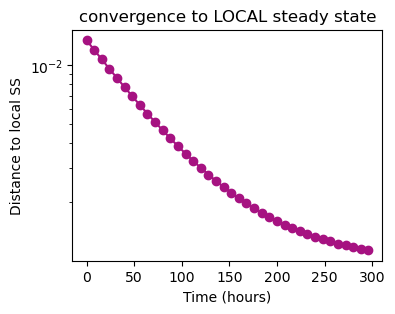

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(range(0, 300, 8), distances, '-o', color='#A61281')
ax.set_yscale("log")
ax.set_title("convergence to LOCAL steady state")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance to local SS")

# departure from the linear is the due to the nonlinearity ==> in linear systems this convergence 
# derivative of this is the eigenvalue 

In [8]:
import imageio
import os

folder  = "gif/"
images = []
for file_name in sorted(os.listdir(folder)):
    if file_name.endswith('.png'):
        file_path = os.path.join(folder, file_name)
        images.append(imageio.imread(file_path))
imageio.mimwrite('time_evolution_%s.gif' % txt, images, fps=3)
print(txt)

/tmp/ipykernel_1053619/1301611190.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


ValueError: all input arrays must have the same shape